In [1]:
# classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# modules to handle data
import pandas as pd
import numpy as np

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# environment setup
sns.set()
plt.style.use('ggplot')
%matplotlib notebook

In [4]:
# load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
# save PassengerId for final submission
passengerId = test.PassengerId

# merge train and test
titanic = train.append(test, ignore_index=True)

In [6]:
# create indexes to separate data later on
train_idx = len(train)
test_idx = len(titanic) - len(test)

In [7]:
# view head of data
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [8]:
# get info on features
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [9]:
# PassengerId can be removed from data for now
titanic.drop('PassengerId', axis=1, inplace=True)

In [10]:
# create a new feature to extract title names from the Name column
titanic['Title'] = titanic.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

# view the newly created feature
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,Mr


In [11]:
# show count of titles
print("There are {} unique titles.".format(titanic.Title.nunique()))

# show unique titles
print("\n", titanic.Title.unique())

There are 18 unique titles.

 ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


In [12]:
# normalize the titles
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

In [13]:
# map the normalized titles to the current titles
titanic.Title = titanic.Title.map(normalized_titles)

# view value counts for the normalized titles
print(titanic.Title.value_counts())

Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64


In [14]:
# group by Sex, Pclass, and Title
grouped = titanic.groupby(['Sex','Pclass', 'Title'])

# view the median Age by the grouped features
grouped.Age.median()

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        45.0
                Officer    49.0
                Royalty    39.0
        2       Miss       20.0
                Mrs        30.0
        3       Miss       18.0
                Mrs        31.0
male    1       Master      6.0
                Mr         41.5
                Officer    52.0
                Royalty    40.0
        2       Master      2.0
                Mr         30.0
                Officer    41.5
        3       Master      6.0
                Mr         26.0
Name: Age, dtype: float64

In [15]:
# apply the grouped median value on the Age NaN
titanic.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))

# view changes
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age         1309 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
Ticket      1309 non-null object
Title       1309 non-null object
dtypes: float64(3), int64(3), object(6)
memory usage: 122.8+ KB


In [16]:
# fill Cabin NaN with U for unknown
titanic.Cabin = titanic.Cabin.fillna('U')

In [17]:
# find most frequent Embarked value and store in variable
most_embarked = titanic.Embarked.value_counts().index[0]

# fill NaN with most_embarked value
titanic.Embarked = titanic.Embarked.fillna(most_embarked)

In [18]:
# fill NaN with median fare
titanic.Fare = titanic.Fare.fillna(titanic.Fare.median())

# view changes
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age         1309 non-null float64
Cabin       1309 non-null object
Embarked    1309 non-null object
Fare        1309 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
Ticket      1309 non-null object
Title       1309 non-null object
dtypes: float64(3), int64(3), object(6)
memory usage: 122.8+ KB


In [19]:
# view the percentage of those that survived vs. those that died in the Titanic
titanic.Survived.value_counts(normalize=True)

0.0    0.616162
1.0    0.383838
Name: Survived, dtype: float64

In [20]:
# group by sex
group_by_sex = titanic.groupby('Sex')

# survival rate by sex
group_by_sex.Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [21]:
# group by sex
group_by_sex = titanic.groupby('Sex')

# survival rate by sex
group_by_sex.Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

<IPython.core.display.Javascript object>


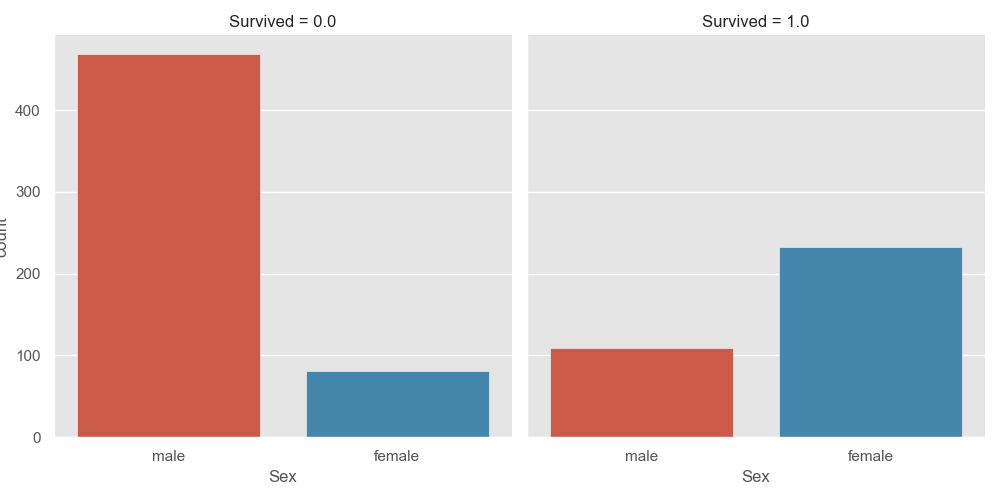

In [22]:
# plot by Survivded, Sex
_ = sns.factorplot(x='Sex', col='Survived', data=titanic, kind='count')

<IPython.core.display.Javascript object>


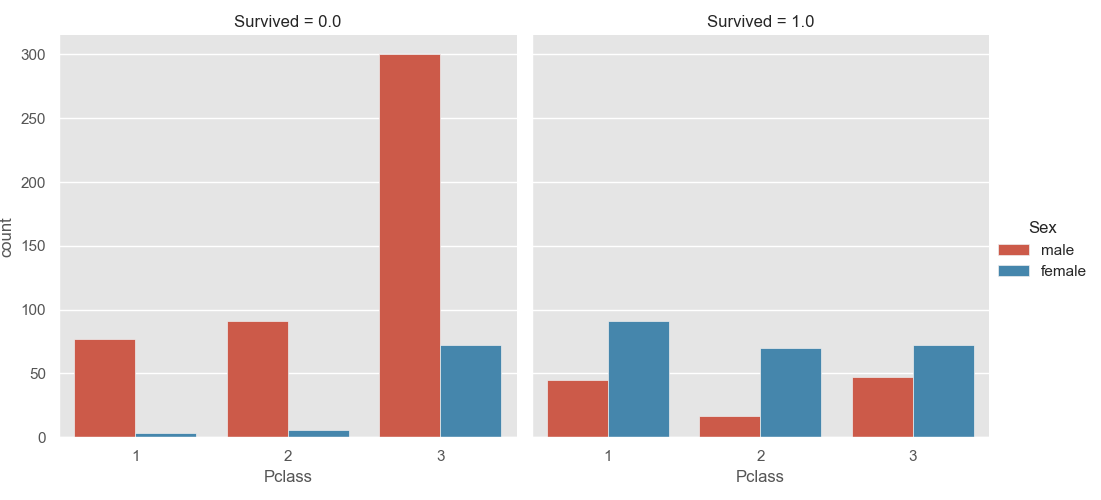

In [23]:
# plot by Pclass, Sex, Survived
_ = sns.factorplot(x='Pclass', hue='Sex', col='Survived', data=titanic, kind='count')

In [24]:
# get stats on all the features
titanic.describe()

,Age,Fare,Parch,Pclass,SibSp,Survived
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.278205,33.281086,0.385027,2.294882,0.498854,0.383838
std,13.446690,51.741500,0.865560,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,2.000000,0.000000,0.000000
50%,26.000000,14.454200,0.000000,3.000000,0.000000,0.000000
75%,36.500000,31.275000,0.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,3.000000,8.000000,1.000000


In [25]:
# size of families (including the passenger)
titanic['FamilySize'] = titanic.Parch + titanic.SibSp + 1

In [26]:
# map first letter of cabin to itself
titanic.Cabin = titanic.Cabin.map(lambda x: x[0])

# view normalized count
titanic.Cabin.value_counts(normalize=True)

U    0.774637
C    0.071811
B    0.049656
D    0.035141
E    0.031322
A    0.016807
F    0.016043
G    0.003820
T    0.000764
Name: Cabin, dtype: float64

In [27]:
titanic.head()


,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize
0,22.0,U,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,Mr,2
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,Mrs,2
2,26.0,U,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,Miss,1
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,Mrs,2
4,35.0,U,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,Mr,1


In [29]:
# Convert the male and female groups to integer form
titanic.Sex = titanic.Sex.map({"male": 0, "female":1})

In [30]:
# create dummy variables for categorical features
pclass_dummies = pd.get_dummies(titanic.Pclass, prefix="Pclass")
title_dummies = pd.get_dummies(titanic.Title, prefix="Title")
cabin_dummies = pd.get_dummies(titanic.Cabin, prefix="Cabin")
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix="Embarked")

In [31]:
# concatenate dummy columns with main dataset
titanic_dummies = pd.concat([titanic, pclass_dummies, title_dummies, cabin_dummies, embarked_dummies], axis=1)

# drop categorical fields
titanic_dummies.drop(['Pclass', 'Title', 'Cabin', 'Embarked', 'Name', 'Ticket'], axis=1, inplace=True)

titanic_dummies.head()

,Age,Fare,Parch,Sex,SibSp,Survived,FamilySize,Pclass_1,Pclass_2,Pclass_3,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S
0,22.0,7.2500,0,0,1,0.0,2,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,38.0,71.2833,0,1,1,1.0,2,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,26.0,7.9250,0,1,0,1.0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,35.0,53.1000,0,1,1,1.0,2,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,35.0,8.0500,0,0,0,0.0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1


In [32]:
# create train and test data
train = titanic_dummies[ :train_idx]
test = titanic_dummies[test_idx: ]

# convert Survived back to int
train.Survived = train.Survived.astype(int)

In [33]:
# create X and y for data and target values
X = train.drop('Survived', axis=1).values
y = train.Survived.values


In [34]:
# create array for test set
X_test = test.drop('Survived', axis=1).values

In [35]:
# create param grid object
log_params = dict(
    C = np.logspace(-5, 8, 15),
    penalty = ['l1', 'l2']
)

In [36]:
# instantiate logistic regressor
log = LogisticRegression()

# load param grid and log model into GridSearcCV
logreg_cv = GridSearchCV(estimator=log, param_grid=log_params, cv=5)

# fit model
logreg_cv.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08]),
                         'penalty': ['l1', 

In [37]:
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 3.727593720314938, 'penalty': 'l2'}
Best score is 0.8294051627384961


In [38]:
# predict on test set for submission
# log_pred = logreg_cv.predict(X_test)

In [39]:
# create param grid object
forrest_params = dict(
    max_depth = [n for n in range(9, 14)],
    min_samples_split = [n for n in range(4, 11)],
    min_samples_leaf = [n for n in range(2, 5)],
    n_estimators = [n for n in range(10, 60, 10)],
)

In [40]:
# instantiate Random Forest model
forrest = RandomForestClassifier()

In [41]:
# build and fit model
forest_cv = GridSearchCV(estimator=forrest, param_grid=forrest_params, cv=5)
forest_cv.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [42]:
# print("Best score: {}".format(forest_model.best_score_))
# print("Optimal params: {}".format(forest_model.best_estimator_))
print("Best score: {}".format(forest_cv.best_score_))
print("Optimal params: {}".format(forest_cv.best_estimator_))

Best score: 0.8406285072951739
Optimal params: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [43]:
# random forrest prediction on test set
forrest_pred = forest_cv.predict(X_test)

In [44]:
# dataframe with predictions
kaggle = pd.DataFrame( {'PassengerId': passengerId, 'Survived': forrest_pred} )

In [45]:
# ensure df is in the right format
kaggle.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [46]:
# ensure df is in the right format
kaggle.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [48]:
# save to csv
kaggle.to_csv('titanic_pred.csv', index=False)